# Purpose

### 2022-02-14
In this notebook I'll select the clusters for the new FPR experiments for Canada, UK, Australia, & India.

Note that this is supposed to be an SFW experiment, so we'll need to filter out subreddits that are `over_18` or rated as `X`.

In one sheet include BOTH subreddit names & subreddit IDs.

TODO: Haven't included place logic (e.g., add direction to: city, state, country subreddits.)


### Updates



# Imports & notebook setup

In [12]:
%load_ext autoreload
%autoreload 2

# Register bigquery magic
%load_ext google.cloud.bigquery

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# auth for google sheets
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [3]:
# Regular Imports
import os
from datetime import datetime

from google.cloud import bigquery

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib_venn import venn2_unweighted, venn3_unweighted


# os.environ['GOOGLE_CLOUD_PROJECT'] = 'data-science-prod-218515'
os.environ['GOOGLE_CLOUD_PROJECT'] = 'data-prod-165221'

In [46]:
# subclu imports
import subclu
from subclu.utils.eda import (
    setup_logging, counts_describe, value_counts_and_pcts,
    notebook_display_config, print_lib_versions,
    style_df_numeric, reorder_array,
)
from subclu.models.clustering_utils import (
    create_dynamic_clusters,
    convert_distance_or_ab_to_list_for_fpr
)


setup_logging()
notebook_display_config()
print_lib_versions([gspread, pd, np])

python		v 3.7.11
===
gspread		v: 5.0.0
pandas		v: 1.2.4
numpy		v: 1.19.5


# Load subreddit metadata

This data is already in bigQuery so read it straight from there. We'll use it to filter out geo-relevant (German) subs.

Also add the latest ratings so that we can filter based on those.

English-speaking countries don't have ambassador subs right now, so we should be able to create a standard template and replace the country name for these queries.

## SQL query

In [8]:
%%time

sql_geo_and_languages = fr"""
-- Select geo+cultural subreddits for a target country
--  And add latest rating & over_18 flags to exclude X-rated & over_18
DECLARE TARGET_COUNTRY STRING DEFAULT 'Australia';


SELECT    
    s.* EXCEPT(over_18, pt, verdict) 
    , nt.rating_name
    , nt.primary_topic
    , nt.rating_short
    , slo.over_18
    , CASE 
        WHEN(COALESCE(slo.over_18, 'f') = 't') THEN 'over_18_or_X_M_D_V'
        WHEN(COALESCE(nt.rating_short, '') IN ('X', 'M', 'D', 'V')) THEN 'over_18_or_X_M_D_V'
        ELSE 'unrated_or_E'
    END AS grouped_rating

FROM `reddit-employee-datasets.david_bermejo.subclu_v0041_subreddit_clusters_c_a` AS t
    -- Inner join b/c we only want to keep subs that are geo-relevant AND in topic model
    INNER JOIN (
        SELECT *
        FROM `reddit-employee-datasets.david_bermejo.subclu_subreddit_geo_score_standardized_20220212`
        WHERE country_name = TARGET_COUNTRY
    ) AS s
        ON t.subreddit_id = s.subreddit_id

    -- Add rating so we can get an estimate for how many we can actually use for recommendation
    LEFT JOIN (
        SELECT *
        FROM `data-prod-165221.ds_v2_postgres_tables.subreddit_lookup`
        -- Get latest partition
        WHERE dt = DATE(CURRENT_DATE() - 2)
    ) AS slo
    ON s.subreddit_id = slo.subreddit_id
    LEFT JOIN (
        SELECT * FROM `data-prod-165221.cnc.shredded_crowdsource_topic_and_rating`
        WHERE pt = DATE(CURRENT_DATE() - 2)
    ) AS nt
        ON s.subreddit_id = nt.subreddit_id

    -- Exclude popular US subreddits
    -- Can't query this table from local notebook because of errors getting google drive permissions. smh, excludefor now
    -- LEFT JOIN `reddit-employee-datasets.david_bermejo.subclu_subreddits_top_us_to_exclude_from_relevance` tus
    --     ON s.subreddit_name = LOWER(tus.subreddit_name)

WHERE 1=1
    AND s.subreddit_name != 'profile'
    AND COALESCE(s.type, '') = 'public'
    AND COALESCE(s.verdict, 'f') <> 'admin_removed'
    AND COALESCE(slo.over_18, 'f') = 'f'
    AND COALESCE(nt.rating_short, '') NOT IN ('X', 'D')

    AND(
        s.geo_relevance_default = TRUE
        OR s.relevance_percent_by_subreddit = TRUE
        OR s.relevance_percent_by_country_standardized = TRUE
    )
    AND country_name IN (
            TARGET_COUNTRY
        )

    -- AND (
    --     -- Exclude subs that are top in US but we want to exclude as culturally relevant
    --     --  For simplicity, let's go with the English exclusion (more relaxed) than the non-English one
    --     COALESCE(tus.english_exclude_from_relevance, '') <> 'exclude'
    -- )

ORDER BY e_users_percent_by_country_standardized DESC, users_l7 DESC, subreddit_name
;
"""

client = bigquery.Client()
df_geo_and_lang = client.query(sql_geo_and_languages).to_dataframe()
print(df_geo_and_lang.shape)

(1433, 25)
CPU times: user 74.4 ms, sys: 37.4 ms, total: 112 ms
Wall time: 10.1 s


## Check data with geo + language information

In [9]:
df_geo_and_lang.head()

,subreddit_id,subreddit_name,country_name,geo_relevance_default,b_users_percent_by_subreddit,e_users_percent_by_country_standardized,c_users_percent_by_country,d_users_percent_by_country_rank,relevance_percent_by_subreddit,relevance_percent_by_country_standardized,...,users_l7,num_of_countries_with_visits_l28,users_percent_by_country_avg,users_percent_by_country_stdev,type,rating_name,primary_topic,rating_short,over_18,grouped_rating
0,t5_2qkhb,melbourne,Australia,True,0.669184,10.780123,0.029058,3,True,True,...,414195,119,0.000542,0.002645,public,Everyone,Place,E,f,unrated_or_E
1,t5_2qkob,sydney,Australia,True,0.821898,10.706480,0.019942,10,True,True,...,201481,117,0.000290,0.001836,public,Everyone,Place,E,f,unrated_or_E
2,t5_2uo3q,ausfinance,Australia,True,0.831555,10.663609,0.018428,14,True,True,...,204175,116,0.000261,0.001704,public,Everyone,"Business, Economics, and Finance",E,None,unrated_or_E
3,t5_2qh8e,australia,Australia,True,0.414442,10.460037,0.046857,2,True,True,...,633423,119,0.001887,0.004299,public,Everyone,Place,E,f,unrated_or_E
4,t5_2g3blu,coronavirusdownunder,Australia,True,0.360947,10.406553,0.020909,8,True,True,...,654697,119,0.000845,0.001928,public,Everyone,Place,E,None,unrated_or_E


In [10]:
df_geo_and_lang.tail()

,subreddit_id,subreddit_name,country_name,geo_relevance_default,b_users_percent_by_subreddit,e_users_percent_by_country_standardized,c_users_percent_by_country,d_users_percent_by_country_rank,relevance_percent_by_subreddit,relevance_percent_by_country_standardized,...,users_l7,num_of_countries_with_visits_l28,users_percent_by_country_avg,users_percent_by_country_stdev,type,rating_name,primary_topic,rating_short,over_18,grouped_rating
1428,t5_3p4uu,pppoker,Australia,True,0.181644,-0.013817,4.391619e-06,46810,True,False,...,100,16,4.561865e-06,1.232122e-05,public,Mature,None,M,f,over_18_or_X_M_D_V
1429,t5_5d99cb,skulduggerysubreddit,Australia,True,0.130597,-0.015117,1.617965e-06,66419,False,False,...,77,10,1.662482e-06,2.944914e-06,public,Everyone,"Reading, Writing, and Literature",E,None,unrated_or_E
1430,t5_4chanv,polygirlsgonewild,Australia,False,0.302839,-0.020905,8.875694e-05,8175,True,False,...,1549,11,9.433286e-05,2.667320e-04,public,None,None,None,None,unrated_or_E
1431,t5_2vxyq,nrlwarriors,Australia,True,0.305019,-0.277847,3.651978e-06,50299,True,False,...,80,5,7.874533e-06,1.519741e-05,public,Everyone,None,E,None,unrated_or_E
1432,t5_2umjs,thelettera,Australia,True,0.021127,-0.991383,4.160481e-07,91801,False,False,...,157,20,9.029383e-07,4.911221e-07,public,Everyone,Internet Culture and Memes,E,None,unrated_or_E


# Load model labels

The clusters now live in a big Query table and have standardized names, so pull the data from there.

## Pull data from BigQuery


In [21]:
%%time
%%bigquery df_labels --project data-science-prod-218515 

-- select subreddit clusters from bigQuery

SELECT
    sc.subreddit_id
    , sc.subreddit_name
    , nt.primary_topic

    , sc.* EXCEPT(subreddit_id, subreddit_name, primary_topic_1214)
FROM `reddit-employee-datasets.david_bermejo.subclu_v0041_subreddit_clusters_c_a` sc
    LEFT JOIN (
        -- New view should be visible to all, but still comes from cnc_taxonomy_cassandra_sync
        SELECT * FROM `data-prod-165221.cnc.shredded_crowdsource_topic_and_rating`
        WHERE DATE(pt) = (CURRENT_DATE() - 2)
    ) AS nt
        ON sc.subreddit_id = nt.subreddit_id
;

Downloading: 100%|██████████████████████████████████████████████████████████| 49558/49558 [00:01<00:00, 35095.00rows/s]

CPU times: user 283 ms, sys: 184 ms, total: 467 ms
Wall time: 6.16 s


In [24]:
print(df_labels.shape)
df_labels.head()

(49558, 51)


,subreddit_id,subreddit_name,primary_topic,model_sort_order,posts_for_modeling_count,k_0013_label,k_0023_label,k_0041_label,k_0059_label,k_0063_label,...,k_2207_majority_primary_topic,k_2351_majority_primary_topic,k_2830_majority_primary_topic,k_3145_majority_primary_topic,k_3411_majority_primary_topic,k_3706_majority_primary_topic,k_3864_majority_primary_topic,k_3927_majority_primary_topic,table_creation_date,mlflow_run_uuid
0,t5_5a9iie,progonlydj,None,40079,1000,12,19,34,49,52,...,Music,Music,Music,Music,Music,Music,Music,Music,2022-02-03 20:37:02.045516+00:00,e37b0a2c3af54c588818e7efdde15df5
1,t5_2x9c7,googleplaymusic,Music,40080,31,12,19,34,49,52,...,Music,Music,Music,Music,Music,Music,Music,Music,2022-02-03 20:37:02.045516+00:00,e37b0a2c3af54c588818e7efdde15df5
2,t5_3jzsk,ravedj,Music,40081,1000,12,19,34,49,52,...,Music,Music,Music,Music,Music,Music,Music,Music,2022-02-03 20:37:02.045516+00:00,e37b0a2c3af54c588818e7efdde15df5
3,t5_2rgie,happyhardcore,Music,40082,152,12,19,34,49,52,...,Music,Music,Music,Music,Music,Music,Music,Music,2022-02-03 20:37:02.045516+00:00,e37b0a2c3af54c588818e7efdde15df5
4,t5_2ruv2,ukhardcore,None,40083,21,12,19,34,49,52,...,Music,Music,Music,Music,Music,Music,Music,Music,2022-02-03 20:37:02.045516+00:00,e37b0a2c3af54c588818e7efdde15df5


In [25]:
counts_describe(df_labels)

,dtype,count,unique,unique-percent,null-count,null-percent
subreddit_id,object,"49,558","49,558",100.00%,0,0.00%
subreddit_name,object,"49,558","49,558",100.00%,0,0.00%
primary_topic,object,"40,700",52,0.13%,"8,858",17.87%
model_sort_order,int64,"49,558","49,558",100.00%,0,0.00%
posts_for_modeling_count,int64,"49,558",999,2.02%,0,0.00%
k_0013_label,int64,"49,558",13,0.03%,0,0.00%
k_0023_label,int64,"49,558",23,0.05%,0,0.00%
k_0041_label,int64,"49,558",41,0.08%,0,0.00%
k_0059_label,int64,"49,558",59,0.12%,0,0.00%
k_0063_label,int64,"49,558",63,0.13%,0,0.00%


# Keep only labels for Target subreddits


In [47]:
l_ix_subs = ['subreddit_name', 'subreddit_id']

df_labels_target = (
    df_labels
    .merge(
        df_geo_and_lang
        .drop(['primary_topic'], axis=1)
        ,
        how='right',
        on=l_ix_subs,
    )
    .copy()
    .sort_values(by=['model_sort_order'], ascending=True)
)

# move some columns to the end of the file
l_cols_to_end = ['table_creation_date', 'mlflow_run_uuid']

df_labels_target = df_labels_target[
    df_labels_target.drop(l_cols_to_end, axis=1).columns.to_list() +
    l_cols_to_end
]

# move cols to front
l_cols_to_front = [
    'subreddit_id',
    'subreddit_name',
    'primary_topic',
    'rating_short',
    'rating_name',
    'over_18',
]
df_labels_target = df_labels_target[
    reorder_array(l_cols_to_front, df_labels_target.columns)
]
print(df_labels_target.shape)

(1433, 73)


In [48]:
df_labels_target.head()

,subreddit_id,subreddit_name,primary_topic,rating_short,rating_name,over_18,model_sort_order,posts_for_modeling_count,k_0013_label,k_0023_label,k_0041_label,k_0059_label,k_0063_label,k_0079_label,k_0085_label,k_0118_label,k_0320_label,k_0657_label,k_0958_label,k_1065_label,k_1560_label,k_1840_label,k_2207_label,k_2351_label,k_2830_label,k_3145_label,k_3411_label,k_3706_label,k_3864_label,k_3927_label,...,k_1840_majority_primary_topic,k_2207_majority_primary_topic,k_2351_majority_primary_topic,k_2830_majority_primary_topic,k_3145_majority_primary_topic,k_3411_majority_primary_topic,k_3706_majority_primary_topic,k_3864_majority_primary_topic,k_3927_majority_primary_topic,country_name,geo_relevance_default,b_users_percent_by_subreddit,e_users_percent_by_country_standardized,c_users_percent_by_country,d_users_percent_by_country_rank,relevance_percent_by_subreddit,relevance_percent_by_country_standardized,users_in_subreddit_from_country_l28,total_users_in_country_l28,total_users_in_subreddit_l28,geo_country_code,posts_not_removed_l28,users_l7,num_of_countries_with_visits_l28,users_percent_by_country_avg,users_percent_by_country_stdev,type,grouped_rating,table_creation_date,mlflow_run_uuid
424,t5_44faux,neighboursbabez,Mature Themes and Adult Content,None,None,None,334,36,1,1,1,1,1,1,1,1,3,5,6,7,10,10,13,13,21,23,26,30,31,31,...,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Australia,False,0.117099,2.921178,0.000038,14648,False,True,817,21632112,6977,AU,22,2140,64,0.000012,0.000009,public,unrated_or_E,2022-02-03 20:37:02.045516+00:00,e37b0a2c3af54c588818e7efdde15df5
1247,t5_iqt8v,altladyboners,Celebrity,E,Everyone,f,489,108,1,1,1,1,1,2,2,2,4,8,11,13,18,19,24,25,35,40,45,52,54,55,...,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Australia,False,0.056172,2.060629,0.000056,11348,False,True,1205,21632112,21452,AU,53,5521,102,0.000027,0.000014,public,unrated_or_E,2022-02-03 20:37:02.045516+00:00,e37b0a2c3af54c588818e7efdde15df5
1238,t5_3g9c8,rtgirls,Podcasts and Streamers,E,Everyone,None,509,36,1,1,1,1,1,2,2,2,4,8,11,13,19,20,25,26,36,41,46,53,55,56,...,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Australia,False,0.054910,2.064154,0.000026,18574,False,True,562,21632112,10235,AU,16,3134,56,0.000009,0.000008,public,unrated_or_E,2022-02-03 20:37:02.045516+00:00,e37b0a2c3af54c588818e7efdde15df5
437,t5_2bfy1d,neighboursbabes,Mature Themes and Adult Content,E,Everyone,f,510,170,1,1,1,1,1,2,2,2,4,8,11,13,19,20,25,26,36,41,46,53,55,56,...,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Australia,False,0.130450,2.901861,0.000088,8269,False,True,1894,21632112,14519,AU,49,3944,80,0.000023,0.000022,public,unrated_or_E,2022-02-03 20:37:02.045516+00:00,e37b0a2c3af54c588818e7efdde15df5
108,t5_39o6d,aussiebabes,Mature Themes and Adult Content,E,Everyone,None,661,21,1,1,1,1,1,2,2,2,5,9,12,14,22,26,31,32,43,50,55,63,65,66,...,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult 

### Drop subs with too few posts

In the modeling process I drop subreddits with too few posts. We don't have recommendations for them, so let's drop them.

It would also not be a great experience to recommend dead subs.

In [49]:
col_sort_order = 'model_sort_order'

print(f"{df_labels_target[col_sort_order].isnull().sum():,.0f} <- subs to drop")
df_labels_target = df_labels_target[
    ~df_labels_target[col_sort_order].isnull()
].copy()
df_labels_target[col_sort_order] = df_labels_target[col_sort_order].astype(int)

l_cols_label_de = [c for c in df_labels_target.columns if c.endswith('_label')]
df_labels_target[l_cols_label_de] = df_labels_target[l_cols_label_de].astype(int)

df_labels_target.shape

0 <- subs to drop


(1433, 73)

In [50]:
style_df_numeric(
    df_labels_target.head(10),
    # rename_cols_for_display=True,
    pct_labels=['_percent_in_country', '_percent'],
    int_labels=None,
    pct_cols=['users_percent_in_country'],
    l_bar_simple=[c for c in df_labels_target.columns if '_label' in c]
)

,subreddit_id,subreddit_name,primary_topic,rating_short,rating_name,over_18,model_sort_order,posts_for_modeling_count,k_0013_label,k_0023_label,k_0041_label,k_0059_label,k_0063_label,k_0079_label,k_0085_label,k_0118_label,k_0320_label,k_0657_label,k_0958_label,k_1065_label,k_1560_label,k_1840_label,k_2207_label,k_2351_label,k_2830_label,k_3145_label,k_3411_label,k_3706_label,k_3864_label,k_3927_label,k_0013_majority_primary_topic,k_0023_majority_primary_topic,k_0041_majority_primary_topic,k_0059_majority_primary_topic,k_0063_majority_primary_topic,k_0079_majority_primary_topic,k_0085_majority_primary_topic,k_0118_majority_primary_topic,k_0320_majority_primary_topic,k_0657_majority_primary_topic,k_0958_majority_primary_topic,k_1065_majority_primary_topic,k_1560_majority_primary_topic,k_1840_majority_primary_topic,k_2207_majority_primary_topic,k_2351_majority_primary_topic,k_2830_majority_primary_topic,k_3145_majority_primary_topic,k_3411_majority_primary_topic,k_3706_majority_primary_topic,k_3864_majority_primary_topic,k_3927_majority_primary_topic,country_name,geo_relevance_default,b_users_percent_by_subreddit,e_users_percent_by_country_standardized,c_users_percent_by_country,d_users_percent_by_country_rank,relevance_percent_by_subreddit,relevance_percent_by_country_standardized,users_in_subreddit_from_country_l28,total_users_in_country_l28,total_users_in_subreddit_l28,geo_country_code,posts_not_removed_l28,users_l7,num_of_countries_with_visits_l28,users_percent_by_country_avg,users_percent_by_country_stdev,type,grouped_rating,table_creation_date,mlflow_run_uuid
424,t5_44faux,neighboursbabez,Mature Themes and Adult Content,None,None,None,334,36,1,1,1,1,1,1,1,1,3,5,6,7,10,10,13,13,21,23,26,30,31,31,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Celebrity,Celebrity,Celebrity,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Australia,False,11.71%,3,0,"14,648",False,True,817,"21,632,112","6,977",AU,22,"2,140",64,0,0,public,unrated_or_E,2022-02-03 20:37:02.045516+00:00,e37b0a2c3af54c588818e7efdde15df5
1247,t5_iqt8v,altladyboners,Celebrity,E,Everyone,f,489,108,1,1,1,1,1,2,2,2,4,8,11,13,18,19,24,25,35,40,45,52,54,55,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Australia,False,5.62%,2,0,"11,348",False,True,"1,205","21,632,112","21,452",AU,53,"5,521",102,0,0,public,unrated_or_E,2022-02-03 20:37:02.045516+00:00,e37b0a2c3af54c588818e7efdde15df5
1238,t5_3g9c8,rtgirls,Podcasts and Streamers,E,Everyone,None,509,36,1,1,1,1,1,2,2,2,4,8,11,13,19,20,25,26,36,41,46,53,55,56,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Th

In [51]:
style_df_numeric(
    df_labels_target.tail(10),
    # rename_cols_for_display=True,
    pct_labels=['_percent_in_country', '_percent'],
    int_labels=None,
    pct_cols=['users_percent_in_country'],
    l_bar_simple=[c for c in df_labels_target.columns if '_label' in c]
)

,subreddit_id,subreddit_name,primary_topic,rating_short,rating_name,over_18,model_sort_order,posts_for_modeling_count,k_0013_label,k_0023_label,k_0041_label,k_0059_label,k_0063_label,k_0079_label,k_0085_label,k_0118_label,k_0320_label,k_0657_label,k_0958_label,k_1065_label,k_1560_label,k_1840_label,k_2207_label,k_2351_label,k_2830_label,k_3145_label,k_3411_label,k_3706_label,k_3864_label,k_3927_label,k_0013_majority_primary_topic,k_0023_majority_primary_topic,k_0041_majority_primary_topic,k_0059_majority_primary_topic,k_0063_majority_primary_topic,k_0079_majority_primary_topic,k_0085_majority_primary_topic,k_0118_majority_primary_topic,k_0320_majority_primary_topic,k_0657_majority_primary_topic,k_0958_majority_primary_topic,k_1065_majority_primary_topic,k_1560_majority_primary_topic,k_1840_majority_primary_topic,k_2207_majority_primary_topic,k_2351_majority_primary_topic,k_2830_majority_primary_topic,k_3145_majority_primary_topic,k_3411_majority_primary_topic,k_3706_majority_primary_topic,k_3864_majority_primary_topic,k_3927_majority_primary_topic,country_name,geo_relevance_default,b_users_percent_by_subreddit,e_users_percent_by_country_standardized,c_users_percent_by_country,d_users_percent_by_country_rank,relevance_percent_by_subreddit,relevance_percent_by_country_standardized,users_in_subreddit_from_country_l28,total_users_in_country_l28,total_users_in_subreddit_l28,geo_country_code,posts_not_removed_l28,users_l7,num_of_countries_with_visits_l28,users_percent_by_country_avg,users_percent_by_country_stdev,type,grouped_rating,table_creation_date,mlflow_run_uuid
1333,t5_2qkt4,martialarts,Sports,E,Everyone,f,"48,736","1,000",13,23,41,59,63,79,85,116,311,636,927,"1,034","1,511","1,785","2,142","2,282","2,747","3,048","3,309","3,594","3,748","3,810",Animals and Pets,Anime,Music,Music,Music,Music,Music,Sports,Sports,Sports,Sports,Sports,Sports,Sports,Sports,Sports,Sports,Sports,Sports,Sports,Sports,Sports,Australia,False,5.07%,2,0,"1,682",False,True,"12,297","21,632,112","242,392",AU,"1,258","83,883",119,0,0,public,unrated_or_E,2022-02-03 20:37:02.045516+00:00,e37b0a2c3af54c588818e7efdde15df5
442,t5_2qn02,bjj,Sports,E,Everyone,f,"48,740","1,000",13,23,41,59,63,79,85,116,311,636,927,"1,034","1,511","1,785","2,142","2,282","2,747","3,048","3,309","3,594","3,748","3,810",Animals and Pets,Anime,Music,Music,Music,Music,Music,Sports,Sports,Sports,Sports,Sports,Sports,Sports,Sports,Sports,Sports,Sports,Sports,Sports,Sports,Sports,Australia,False,5.66%,3,0,724,False,True,"27,124","21,632,112","479,233",AU,"2,179","155,916",119,0,0,public,unrated_or_E,2022-02-03 20:37:02.045516+00:00,e37b0a2c3af54c588818e7efdde15df5
1239,t5_2t06q,jiujitsu,Sports,E,Everyone,None,"48,741",152,13,23,41,59,63,79,85,116,311,636,927,"1,034","1,511","1,785","2,142","2,282","2,747","3,048","3,309","3,594","3,748","3,810",Animals and Pets,Anime,Music,Music,Music,Music,Music,Sports,Sports,Sports,Sports,Sports,Sports,Sports,Sports,Sports,Sports,Sports,Sports,Sports,Sports,Sports,Australia,False,4.44%,2,0,"11,514",False,True,"1,181","21,632,112","26,629",AU,145,"7,684",89,0,0,public,unrated_or_E,2022-02-03 20:37:02.045516+00:00,e37b0a2c3af54c588818e7efdde15df5
700,t5_2qhj4,mma,Sports,E,Everyone,f,"48,757","1,000",13,23,41,59,63,79,85,116,311,637,928,"1,035","1,512","1,786","2,143","2,283","2,748","3,049","3,310","3,595","3,749","3,811",Animals and Pets,Anime,Music,Music,Music,Music,Music,Sports,Sports,Sports,Sports,Sports,Sports,Sports,Sports,Sports,Sports,Sports,Sports,Sports,Sports,Sports,Australia,False,5.56%,2,0,199,False,True,"90,404","21,632,112","1,624,548",AU,"1,007","533,579",119,0,0,public,unrated_or_E,2022-02-03 20:37:02.045516+00:00,e37b0a2c3af54c588818e7efdde15df5
649,t5_2sljg,squaredcircle,Sports,E,Everyone,None,"48,790","1,000",13,23,41,59,63,79,85,116,312,638,930,"1,037","1,514","1,788","2,145","2,285","2,750","3,051","3,312","3,598","3,752","3,814",Animals and Pets,Anime,Music,Music,Music,Music,Music,Sports,Sports,Sports,Sports,Sports,Sports,Sports,Sp

In [52]:
# style_df_numeric(
#     df_labels_target.tail(10),
#     # rename_cols_for_display=True,
#     l_bar_simple=[c for c in df_labels_target.columns if '_label' in c]
# )

# Filter out subs

The main use case for now are SFW subs, so let's save some QA time by excluding these subs:
- Exclude NSFW clusters
- Exclude place subs


We'll use the cluster labels to discard subreddits because 
- many of the DE subreddits don't have a `primary_topic`
- if the majority of subs for a subreddits are NSFW, then we wouldn't want to recommend those anyway

In [53]:
value_counts_and_pcts(
    df_labels_target['k_0118_majority_primary_topic'],
    top_n=15,
    reset_index=True,
    add_col_prefix=False,
    count_type='subreddits',
    return_df=False,
)

,k_0118_majority_primary_topic,subreddits_count,percent_of_subreddits,cumulative_percent_of_subreddits
0,Mature Themes and Adult Content,113,7.9%,7.9%
1,Medical and Mental Health,111,7.7%,15.6%
2,Podcasts and Streamers,99,6.9%,22.5%
3,Sports,92,6.4%,29.0%
4,Gaming,83,5.8%,34.8%
5,Home and Garden,80,5.6%,40.3%
6,Cars and Motor Vehicles,68,4.7%,45.1%
7,Animals and Pets,66,4.6%,49.7%
8,"Reading, Writing, and Literature",64,4.5%,54.2%
9,Television,60,4.2%,58.3%


In [54]:
value_counts_and_pcts(
    df_labels_target['k_3145_majority_primary_topic'],
    top_n=15,
    reset_index=True,
    add_col_prefix=False,
    count_type='subreddits',
    return_df=False,
)

,k_3145_majority_primary_topic,subreddits_count,percent_of_subreddits,cumulative_percent_of_subreddits
0,Television,102,7.1%,7.1%
1,Mature Themes and Adult Content,79,5.5%,12.6%
2,Gaming,73,5.1%,17.7%
3,Sports,70,4.9%,22.6%
4,Medical and Mental Health,69,4.8%,27.4%
5,Animals and Pets,62,4.3%,31.8%
6,Home and Garden,61,4.3%,36.0%
7,Food and Drink,60,4.2%,40.2%
8,Podcasts and Streamers,58,4.0%,44.2%
9,Cars and Motor Vehicles,56,3.9%,48.2%


In [55]:
value_counts_and_pcts(
    df_labels_target['k_3927_majority_primary_topic'],
    top_n=15,
    reset_index=True,
    add_col_prefix=False,
    count_type='subreddits',
    return_df=False,
)

,k_3927_majority_primary_topic,subreddits_count,percent_of_subreddits,cumulative_percent_of_subreddits
0,Television,103,7.2%,7.2%
1,Mature Themes and Adult Content,81,5.7%,12.8%
2,Gaming,77,5.4%,18.2%
3,Medical and Mental Health,74,5.2%,23.4%
4,Sports,69,4.8%,28.2%
5,Food and Drink,61,4.3%,32.4%
6,Animals and Pets,60,4.2%,36.6%
7,Home and Garden,59,4.1%,40.8%
8,Cars and Motor Vehicles,56,3.9%,44.7%
9,Place,55,3.8%,48.5%


In [56]:
value_counts_and_pcts(
    df_labels_target['primary_topic'],
    count_type='subreddits',
    reset_index=True,
    add_col_prefix=False,
)

,primary_topic,subreddits_count,percent_of_subreddits,cumulative_percent_of_subreddits
0,nan,197,13.7%,13.7%
1,Television,100,7.0%,20.7%
2,Sports,75,5.2%,26.0%
3,Gaming,73,5.1%,31.1%
4,Medical and Mental Health,60,4.2%,35.2%
5,Food and Drink,51,3.6%,38.8%
6,Podcasts and Streamers,50,3.5%,42.3%
7,Family and Relationships,48,3.3%,45.6%
8,Home and Garden,47,3.3%,48.9%
9,Animals and Pets,46,3.2%,52.1%


In [57]:
print(f"{df_labels_target.shape} <- Shape before filtering")

l_manual_subs_to_remove = [
    'sexmeets1', 'fuck',
]
col_cluster_filter = 'k_3145_majority_primary_topic'
df_labels_target_clean = (
    df_labels_target[df_labels_target[col_cluster_filter] != 'Mature Themes and Adult Content']
)
print(f"{df_labels_target_clean.shape} <- Shape after dropping NSFW clusters")

l_sensitive_topics = [
    'Military', 'Gender', 'Addiction Support',
    'Medical and Mental Health', 'Sexual Orientation',
    'Culture, Race, and Ethnicity',
]
df_labels_target_clean = (
    df_labels_target_clean[
        ~df_labels_target_clean[col_cluster_filter].isin(l_sensitive_topics)
    ]
)
print(f"{df_labels_target_clean.shape} <- Shape after dropping Sensitive clusters")

df_labels_target_clean = (
    df_labels_target_clean[
        ~df_labels_target_clean['primary_topic'].isin(l_sensitive_topics)
    ]
)
print(f"{df_labels_target_clean.shape} <- Shape after dropping SENSITIVE subreddits")


df_labels_target_clean = (
    df_labels_target_clean[
        ~df_labels_target_clean['subreddit_name'].isin(l_manual_subs_to_remove)
    ]
)
print(f"{df_labels_target_clean.shape} <- Shape after dropping Manual list of subreddits")

print(f"  ** TODO: instead of excluding place subs, add logic to map hierarchy **")
# df_labels_target_clean = (
#     df_labels_target_clean[df_labels_target_clean['primary_topic'] != 'Place']
# )
# print(f"{df_labels_target_clean.shape} <- Shape after dropping Place subreddits")

(1433, 73) <- Shape before filtering
(1354, 73) <- Shape after dropping NSFW clusters
(1262, 73) <- Shape after dropping Sensitive clusters
(1246, 73) <- Shape after dropping SENSITIVE subreddits
(1246, 73) <- Shape after dropping Manual list of subreddits
  ** TODO: instead of excluding place subs, add logic to map hierarchy **


# Create new clustering logic to resize clusters

We want to balance two things:
- prevent orphan subreddits
- prevent clusters that are too large to be meaningful

In order to do this at a country level, we'll be better off starting with smallest cluster size and roll up until we have at least N subreddits in one cluster.

For now, let's set the threshold at 5.

In [99]:
# let's exclude  k=014 because at that point the clusters are too generic
col_new_cluster_val = 'cluster_label'
col_new_cluster_name = 'cluster_label_k'
col_new_cluster_prim_topic = 'cluster_majority_primary_topic'

l_cols_labels = [c for c in df_labels_target_clean.columns 
                 if all([c != col_new_cluster_val, c.endswith('_label')])
                 ][1:]


try:
    df_labels_target = df_labels_target.drop(
        [col_new_cluster_val, col_new_cluster_name, col_new_cluster_prim_topic],
        axis=1
    )
    df_labels_target = df_labels_target.drop(
        [c for c in df_labels_target.columns if c.endswith('_label_nested')],
        axis=1
    )
except KeyError:
    pass
try:
    df_labels_target_clean = df_labels_target_clean.drop(
        [col_new_cluster_val, col_new_cluster_name, col_new_cluster_prim_topic],
        axis=1
    )
    df_labels_target_clean = df_labels_target_clean.drop(
        [c for c in df_labels_target_clean.columns if c.endswith('_label_nested')],
        axis=1
    )
except KeyError:
    pass


df_labels_target_dynamic_clean = create_dynamic_clusters(
    df_labels_target_clean,
    agg_strategy='aggregate_small_clusters',
    min_subreddits_in_cluster=5,
    l_cols_labels_input=l_cols_labels,
    col_new_cluster_val=col_new_cluster_val,
    col_new_cluster_prim_topic=col_new_cluster_prim_topic,
)

print(f"*** Dynamic clusters RAW ***")
df_labels_target_dynamic_raw = create_dynamic_clusters(
    df_labels_target,
    agg_strategy='aggregate_small_clusters',
    min_subreddits_in_cluster=9,
    l_cols_labels_input=l_cols_labels,
    col_new_cluster_val=col_new_cluster_val,
    col_new_cluster_name=col_new_cluster_name,
    col_new_cluster_prim_topic=col_new_cluster_prim_topic,
)

k_3864_label_nested
  (558,) <- Shape of clusters below threshold
k_3706_label_nested
  (554,) <- Shape of clusters below threshold
k_3411_label_nested
  (545,) <- Shape of clusters below threshold
k_3145_label_nested
  (529,) <- Shape of clusters below threshold
k_2830_label_nested
  (513,) <- Shape of clusters below threshold
k_2351_label_nested
  (504,) <- Shape of clusters below threshold
k_2207_label_nested
  (467,) <- Shape of clusters below threshold
k_1840_label_nested
  (457,) <- Shape of clusters below threshold
k_1560_label_nested
  (431,) <- Shape of clusters below threshold
k_1065_label_nested
  (406,) <- Shape of clusters below threshold
k_0958_label_nested
  (327,) <- Shape of clusters below threshold
k_0657_label_nested
  (314,) <- Shape of clusters below threshold
k_0320_label_nested
  (245,) <- Shape of clusters below threshold
k_0118_label_nested
  (146,) <- Shape of clusters below threshold
k_0085_label_nested
  (67,) <- Shape of clusters below threshold
k_0079_labe

In [97]:
value_counts_and_pcts(
    df_labels_target_dynamic_clean,
    ['cluster_label'],
    top_n=None,
)

,count,percent,cumulative_percent
cluster_label,,,
011-019-026-027-036-037-047-136-274-404-454-659-777-934-994-1201-1336-1439-1566-1639-1664,22,1.8%,1.8%
012-020-027-028-037-038-048-138-277-409-459-669-790-950-1011-1219-1358-1462-1593-1668-1693,17,1.4%,3.1%
016-029-039-041-052-055-077-217-433-625-699-1010-1187-1430-1521-1815-2018-2181-2364-2464-2498,16,1.3%,4.4%
010-018-025-025-033-034-043,16,1.3%,5.7%
010-017-023-023-031-032-041,14,1.1%,6.8%
017-030-040-043-054-057-082-227-451-651-728-1054-1239-1489-1585-1895-2104-2272-2466-2572-2607,14,1.1%,7.9%
021-037-054-057-072-076-106-287,13,1.0%,9.0%
008-013-017-017-021-022-026,12,1.0%,10.0%
021-037-054-057-072-077-107-289-587-852-948-1381-1634-1953-2081-2503-2771-3001,12,1.0%,10.9%


In [96]:
value_counts_and_pcts(
    df_labels_target_dynamic_raw,
    ['cluster_label'],
    top_n=None,
)

,count,percent,cumulative_percent
cluster_label,,,
015-028-038-040-051-054,27,1.9%,1.9%
010-018-025-025-033-034-043,25,1.7%,3.6%
010-018-025-025-033-034-043-126,25,1.7%,5.4%
010-015-021-021-028-029-034,23,1.6%,7.0%
011-019-026-027-036-037-047-136-274-404-454-659-777-934-994-1201-1336-1439-1566-1639-1664,22,1.5%,8.5%
020-035-051-054-068-072-101-278,21,1.5%,10.0%
010,20,1.4%,11.4%
016-029-039-041-052-055-077,20,1.4%,12.8%
012-021-028-029-038-039-050-143,18,1.3%,14.0%


## Check if there are any single subreddits if we use cluster = 52

We want to avoid having clusters of one subreddit b/c that means we have nothing to recommend.

Looks like even at 52 there are some subreddits that are orphans.

In [66]:
df_labels_target_dynamic_clean.iloc[:5, :15]

,subreddit_id,subreddit_name,posts_for_modeling_count,cluster_label,cluster_label_k,cluster_majority_primary_topic,primary_topic,rating_short,rating_name,over_18,model_sort_order,k_0013_label,k_0023_label,k_0041_label,k_0059_label
365,t5_4dgbcr,laetitiabrown,39,001,k_0023_label,Mature Themes and Adult Content,None,None,None,f,1045,1,1,2,2
160,t5_24v66b,isabelleclarke,3,001,k_0023_label,Mature Themes and Adult Content,Celebrity,E,Everyone,None,1934,1,1,3,3
156,t5_5fbvny,sophadophaa,7,001,k_0023_label,Mature Themes and Adult Content,None,None,None,None,2037,1,1,3,3
35,t5_3aewyu,luciejaid2,6,002,k_0023_label,Mature Themes and Adult Content,Beauty and Makeup,E,Everyone,None,4988,2,2,5,5
1408,t5_4jgdp9,zimaanderson,13,002,k_0023_label,Mature Themes and Adult Content,Celebrity,E,Everyone,None,5644,2,2,5,5


In [87]:
df_labels_target_dynamic_clean.iloc[-15:, :15]

,subreddit_id,subreddit_name,posts_for_modeling_count,cluster_label,cluster_label_k,cluster_majority_primary_topic,primary_topic,rating_short,rating_name,over_18,model_sort_order,k_0013_label,k_0023_label,k_0041_label,k_0059_label
1035,t5_2wtsv,delusionalartists,124,023,k_0023_label,Anime,Funny/Humor,E,Everyone,None,47933,13,23,39,57
204,t5_vv65o,isaacbutterfield,85,023,k_0023_label,Anime,Celebrity,E,Everyone,f,48607,13,23,41,59
928,t5_2r6rj,cringe,692,023,k_0023_label,Anime,Internet Culture and Memes,E,Everyone,f,48677,13,23,41,59
722,t5_2qhkm,comedy,1000,023,k_0023_label,Anime,None,E,Everyone,f,48678,13,23,41,59
546,t5_2r60y,muaythai,977,023-041-059-063-079-085-116-311,k_0320_label,Sports,Sports,E,Everyone,f,48733,13,23,41,59
1333,t5_2qkt4,martialarts,1000,023-041-059-063-079-085-116-311,k_0320_label,Sports,Sports,E,Everyone,f,48736,13,23,41,59
442,t5_2qn02,bjj,1000,023-041-059-063-079-085-116-311,k_0320_label,Sports,Sports,E,Everyone,f,48740,13,23,41,59
1239,t5_2t06q,jiujitsu,152,023-041-059-063-079-085-116-311,k_0320_label,Sports,Sports,E,Everyone,None,48741,13,23,41,59
700,t5_2qhj4,mma,1000,023-041-059-063-079-085-116-311,k_0320_label,Sports,Sports,E,Everyone,f,48757,13,23,41,59
649,t5_2sljg,squaredcircle,1000,023,k_0023_label,Anime,Sports,E,Everyone,None,48790,13,23,41,59


In [68]:
k_label_50s = 'k_0059_label'
df_lbl_counts52 = value_counts_and_pcts(
    df_labels_target_clean[k_label_50s], top_n=None,
    reset_index=True,
    add_col_prefix=False,
    return_df=True,
).sort_values(by=['count'], ascending=False)

df_lbl_counts_dynamic = value_counts_and_pcts(
    df_labels_target_dynamic_clean['cluster_label'], top_n=None,
    reset_index=True,
    add_col_prefix=False,
    return_df=True,
).sort_values(by=['count'], ascending=False)
df_lbl_counts_dynamic.shape

df_lbl_counts_dynamic_raw = value_counts_and_pcts(
    df_labels_target_dynamic_raw['cluster_label'], top_n=None,
    reset_index=True,
    add_col_prefix=False,
    return_df=True,
).sort_values(by=['count'], ascending=False)

style_df_numeric(
    pd.concat(
        [
            df_lbl_counts52['count'].describe().to_frame().rename(columns={'count': f"CLEAN-{k_label_50s.replace('_label', '')}"}).T,
            df_lbl_counts_dynamic['count'].describe().to_frame().rename(columns={'count': 'CLEAN-dynamic_cluster'}).T,
            df_lbl_counts_dynamic_raw['count'].describe().to_frame().rename(columns={'count': 'RAW-dynamic_cluster'}).T,
        ]
    ),
    float_round=3,
)

,count,mean,std,min,25%,50%,75%,max
CLEAN-k_0059,47,26.511,28.535,1.000,4.500,17.000,38.000,155.000
CLEAN-dynamic_cluster,203,6.138,2.525,1.000,5.000,6.000,7.000,22.000
RAW-dynamic_cluster,281,5.100,2.121,1.000,4.000,5.000,6.000,22.000


/Users/david.bermejo/repos/subreddit_clustering_i18n/.venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/david.bermejo/repos/subreddit_clustering_i18n/.venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


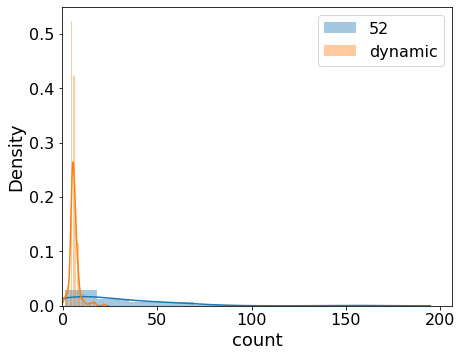

In [69]:
plt.figure(figsize=(7, 5.5))
ax = sns.distplot(df_lbl_counts52['count'], label='52', kde=True)
ax = sns.distplot(df_lbl_counts_dynamic['count'], label='dynamic', kde=True)
plt.legend()
ax.set_xlim(-.5, );

In [45]:
# style_df_numeric(df_lbl_counts52.head(10), l_bar_simple=['count', 'percent'])

In [46]:
# style_df_numeric(df_lbl_counts_dynamic.head(10), l_bar_simple=['count', 'percent'])

In [47]:
# ax = sns.displot(df_lbl_counts52['count'], label='52', kind='kde')
# ax = sns.displot(df_lbl_counts_dynamic['count'], label='dynamic', kind='kde')

In [71]:
l_orphan_cluster_ids = df_lbl_counts52[df_lbl_counts52['count'] <= 1][k_label_50s].values
print(len(l_orphan_cluster_ids))
l_subs_to_check_orphan = ['fitnessde', 'zelten']

df_labels_target_clean[df_labels_target_clean[k_label_50s].isin(l_orphan_cluster_ids)]

5


,subreddit_id,subreddit_name,primary_topic,rating_short,rating_name,over_18,model_sort_order,posts_for_modeling_count,k_0013_label,k_0023_label,k_0041_label,k_0059_label,k_0063_label,k_0079_label,k_0085_label,k_0118_label,k_0320_label,k_0657_label,k_0958_label,k_1065_label,k_1560_label,k_1840_label,k_2207_label,k_2351_label,k_2830_label,k_3145_label,k_3411_label,k_3706_label,k_3864_label,k_3927_label,...,k_1840_majority_primary_topic,k_2207_majority_primary_topic,k_2351_majority_primary_topic,k_2830_majority_primary_topic,k_3145_majority_primary_topic,k_3411_majority_primary_topic,k_3706_majority_primary_topic,k_3864_majority_primary_topic,k_3927_majority_primary_topic,country_name,geo_relevance_default,b_users_percent_by_subreddit,e_users_percent_by_country_standardized,c_users_percent_by_country,d_users_percent_by_country_rank,relevance_percent_by_subreddit,relevance_percent_by_country_standardized,users_in_subreddit_from_country_l28,total_users_in_country_l28,total_users_in_subreddit_l28,geo_country_code,posts_not_removed_l28,users_l7,num_of_countries_with_visits_l28,users_percent_by_country_avg,users_percent_by_country_stdev,type,grouped_rating,table_creation_date,mlflow_run_uuid
365,t5_4dgbcr,laetitiabrown,None,None,None,f,1045,39,1,1,2,2,2,3,3,3,6,12,15,17,28,34,40,41,57,65,71,81,87,88,...,Celebrity,Celebrity,Celebrity,Celebrity,Celebrity,Celebrity,Celebrity,Celebrity,Celebrity,Australia,False,0.293478,3.082660,0.000007,36907,True,True,162,21632112,552,AU,16,194,16,0.000002,0.000002,public,unrated_or_E,2022-02-03 20:37:02.045516+00:00,e37b0a2c3af54c588818e7efdde15df5
774,t5_4qcdkx,jacksonnmaddyof,None,None,None,None,6114,19,2,3,6,6,6,8,9,10,27,54,86,97,153,185,229,250,313,355,389,433,458,463,...,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Celebrity,Celebrity,Celebrity,Celebrity,Celebrity,Australia,False,0.158543,2.371661,0.000074,9250,True,True,1610,21632112,10155,AU,54,3346,99,0.000027,0.000020,public,unrated_or_E,2022-02-03 20:37:02.045516+00:00,e37b0a2c3af54c588818e7efdde15df5
1029,t5_2858fg,communalshowers,None,M,Mature,None,15876,347,5,7,12,15,15,19,20,24,73,139,206,236,351,415,505,540,667,744,805,888,931,943,...,Activism,Hobbies,Hobbies,Hobbies,Hobbies,Hobbies,Hobbies,Hobbies,Hobbies,Australia,False,0.038109,2.180806,0.000083,8601,False,True,1799,21632112,47207,AU,201,13513,102,0.000036,0.000022,public,over_18_or_X_M_D_V,2022-02-03 20:37:02.045516+00:00,e37b0a2c3af54c588818e7efdde15df5
291,t5_2zw1b,connectwise,Technology,E,Everyone,None,16423,113,6,8,13,16,16,20,21,25,76,147,218,249,371,439,533,572,705,789,851,942,987,999,...,Technology,Technology,Technology,Technology,Technology,Technology,Technology,Technology,Technology,Australia,False,0.074786,3.409154,0.000057,11113,False,True,1241,21632112,16594,AU,45,4491,68,0.000013,0.000013,public,unrated_or_E,2022-02-03 20:37:02.045516+00:00,e37b0a2c3af54c588818e7efdde15df5
1422,t5_3nq4o,viberate,Music,E,Everyone,None,18573,23,6,10,15,19,19,26,27,32,93,180,265,302,455,533,643,686,841,940,1016,1114,1166,1179,...,Music,Music,Music,Music,Music,"Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance",Australia,True,0.141053,0.128821,0.000003,53525,True,False,67,21632112,475,AU,7,112,19,0.000002,0.000005,public,unrated_or_E,2022-02-03 20:37:02.045516+00:00,e37b0a2c3af54c588818e7efdde15df5


In [91]:
l_orphan_cluster_ids2 = df_lbl_counts_dynamic[df_lbl_counts_dynamic['count'] <= 1][col_new_cluster_val].values
print(len(l_orphan_cluster_ids2))

(
    df_labels_target_dynamic_clean[df_labels_target_dynamic_clean[col_new_cluster_val].isin(l_orphan_cluster_ids2)]
    .iloc[:, :14]
)

4


,subreddit_id,subreddit_name,posts_for_modeling_count,cluster_label,cluster_label_k,cluster_majority_primary_topic,primary_topic,rating_short,rating_name,over_18,model_sort_order,k_0013_label,k_0023_label,k_0041_label
774,t5_4qcdkx,jacksonnmaddyof,19,003,k_0023_label,Mature Themes and Adult Content,None,None,None,None,6114,2,3,6
1029,t5_2858fg,communalshowers,347,007,k_0023_label,Mature Themes and Adult Content,None,M,Mature,None,15876,5,7,12
291,t5_2zw1b,connectwise,113,008,k_0023_label,Technology,Technology,E,Everyone,None,16423,6,8,13
1424,t5_2vo6a,boro,32,016,k_0023_label,Sports,Sports,E,Everyone,None,32427,10,16,29


# Reshape distance data to include only subs in a cluster

For country-level it's fine to only limit based on cluster ID because we have so few subreddits in some countries. 

For other use cases we might want to limit by only top N subs within a given distance.

### Reshape: flatten topics into 1 row = 1 subreddit with counterpart/cluster subs

See utility function that does reshaping with one call.

In [76]:
col_sort_order

'model_sort_order'

In [78]:
%%time

df_target_to_target_list = convert_distance_or_ab_to_list_for_fpr(
    df_labels_target_dynamic_clean,
    convert_to_ab=True,
    col_counterpart_count='counterpart_count',
    col_list_cluster_names='list_cluster_subreddit_names',
    col_list_cluster_ids='list_cluster_subreddit_ids',
    l_cols_for_seeds=None,
    l_cols_for_clusters=None,
    col_new_cluster_val=col_new_cluster_val,
    col_new_cluster_name=col_new_cluster_name,
    col_new_cluster_prim_topic=col_new_cluster_prim_topic,
    verbose=False,
)
df_target_to_target_list.shape

  (7690, 9) <- df_ab.shape after removing matches to self
  (1242, 7) <- df_a_to_b.shape
CPU times: user 100 ms, sys: 1.77 ms, total: 102 ms
Wall time: 101 ms


(1242, 7)

In [84]:
df_labels_target_clean.shape

(1246, 73)

In [86]:
df_labels_target_clean.head(10)

,subreddit_id,subreddit_name,primary_topic,rating_short,rating_name,over_18,model_sort_order,posts_for_modeling_count,k_0013_label,k_0023_label,k_0041_label,k_0059_label,k_0063_label,k_0079_label,k_0085_label,k_0118_label,k_0320_label,k_0657_label,k_0958_label,k_1065_label,k_1560_label,k_1840_label,k_2207_label,k_2351_label,k_2830_label,k_3145_label,k_3411_label,k_3706_label,k_3864_label,k_3927_label,...,k_1840_majority_primary_topic,k_2207_majority_primary_topic,k_2351_majority_primary_topic,k_2830_majority_primary_topic,k_3145_majority_primary_topic,k_3411_majority_primary_topic,k_3706_majority_primary_topic,k_3864_majority_primary_topic,k_3927_majority_primary_topic,country_name,geo_relevance_default,b_users_percent_by_subreddit,e_users_percent_by_country_standardized,c_users_percent_by_country,d_users_percent_by_country_rank,relevance_percent_by_subreddit,relevance_percent_by_country_standardized,users_in_subreddit_from_country_l28,total_users_in_country_l28,total_users_in_subreddit_l28,geo_country_code,posts_not_removed_l28,users_l7,num_of_countries_with_visits_l28,users_percent_by_country_avg,users_percent_by_country_stdev,type,grouped_rating,table_creation_date,mlflow_run_uuid
365,t5_4dgbcr,laetitiabrown,None,None,None,f,1045,39,1,1,2,2,2,3,3,3,6,12,15,17,28,34,40,41,57,65,71,81,87,88,...,Celebrity,Celebrity,Celebrity,Celebrity,Celebrity,Celebrity,Celebrity,Celebrity,Celebrity,Australia,False,0.293478,3.082660,0.000007,36907,True,True,162,21632112,552,AU,16,194,16,0.000002,0.000002,public,unrated_or_E,2022-02-03 20:37:02.045516+00:00,e37b0a2c3af54c588818e7efdde15df5
160,t5_24v66b,isabelleclarke,Celebrity,E,Everyone,None,1934,3,1,1,3,3,3,4,4,4,10,18,25,28,46,54,61,67,89,102,113,128,136,137,...,Celebrity,Celebrity,Celebrity,Celebrity,Celebrity,Celebrity,Celebrity,Celebrity,Celebrity,Australia,False,0.226393,4.791037,0.000026,18368,True,True,573,21632112,2531,AU,9,456,52,0.000006,0.000004,public,unrated_or_E,2022-02-03 20:37:02.045516+00:00,e37b0a2c3af54c588818e7efdde15df5
156,t5_5fbvny,sophadophaa,None,None,None,None,2037,7,1,1,3,3,3,4,4,4,10,19,26,29,47,56,64,70,93,106,117,132,141,142,...,Celebrity,Celebrity,Celebrity,Celebrity,Celebrity,Celebrity,Celebrity,Celebrity,Celebrity,Australia,True,0.368350,4.849986,0.000038,14644,True,True,817,21632112,2218,AU,48,400,36,0.000005,0.000007,public,unrated_or_E,2022-02-03 20:37:02.045516+00:00,e37b0a2c3af54c588818e7efdde15df5
35,t5_3aewyu,luciejaid2,Beauty and Makeup,E,Everyone,None,4988,6,2,2,5,5,5,7,8,9,19,42,60,70,110,134,165,183,234,270,295,326,347,352,...,Mature Themes and Adult Content,Funny/Humor,Funny/Humor,Funny/Humor,Funny/Humor,Funny/Humor,Funny/Humor,Funny/Humor,Funny/Humor,Australia,True,0.473006,7.916837,0.000268,3374,True,True,5800,21632112,12262,AU,10,4317,69,0.000016,0.000032,public,unrated_or_E,2022-02-03 20:37:02.045516+00:00,e37b0a2c3af54c588818e7efdde15df5
1408,t5_4jgdp9,zimaanderson,Celebrity,E,Everyone,None,5644,13,2,2,5,5,5,7,8,9,23,49,76,87,137,165,204,224,283,321,355,396,419,424,...,Celebrity,Celebrity,Celebrity,Celebrity,Celebrity,Celebrity,Celebrity,Celebrity,Celebrity,Australia,False,0.202956,0.681826,0.000010,32736,True,False,206,21632112,1015,AU,6,260,13,0.000005,0.000007,public,unrated_or_E,2022-02-03 20:37:02.045516+00:00,e37b0a2c3af54c588818e7efdde15df5
774,t5_4qcdkx,jacksonnmaddyof,None,None,None,None,6114,19,2,3,6,6,6,8,9,10,27,54,86,97,153,185,229,250,313,355,389,433,458,463,...,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Mature Themes and Adult Content,Celebrity,Celebrity,Celebrity,Celebrity,Celebrity,Australia,False,0.158543,2.371661,0.000074,9250,True,True,1610,21632112,10155,AU,54,3346,99,0.000027,0.000020,public,unrated_or_E,2022-02-03 20:37:02.045516+00:00,e37b0a2c3af54c588818e7efdde15df5
239,t5_24s9xa,brisbanesocial,None,E,Everyone,f,12195,52,4,6,11,13,13,16,17,19,55,106,154,177,264,316,391,418,520,581,629,694,728,737,...,Place,Place,Place,Place,Place,Place,Place,Place,Place,Australia,T

In [83]:
df_target_to_target_list.head(10)

,subreddit_name_seed,subreddit_id_seed,cluster_label,cluster_label_k,counterpart_count,list_cluster_subreddit_names,list_cluster_subreddit_ids
0,laetitiabrown,t5_4dgbcr,001,k_0023_label,2,"isabelleclarke, sophadophaa","t5_24v66b, t5_5fbvny"
1,isabelleclarke,t5_24v66b,001,k_0023_label,2,"laetitiabrown, sophadophaa","t5_4dgbcr, t5_5fbvny"
2,sophadophaa,t5_5fbvny,001,k_0023_label,2,"laetitiabrown, isabelleclarke","t5_4dgbcr, t5_24v66b"
3,luciejaid2,t5_3aewyu,002,k_0023_label,1,zimaanderson,t5_4jgdp9
4,zimaanderson,t5_4jgdp9,002,k_0023_label,1,luciejaid2,t5_3aewyu
5,brisbanesocial,t5_24s9xa,006,k_0023_label,1,amwfdating,t5_38ezr
6,amwfdating,t5_38ezr,006,k_0023_label,1,brisbanesocial,t5_24s9xa
7,googlewifi,t5_3ggya,008-013-017-017-021-022-026,k_0118_label,11,"nestwifi, talesfromtechsupport, msp, googlehome, carplay, hisense, chromecast, animelab, funimation, thepiratebays, pocketcasts","t5_26mrs3, t5_2sfg5, t5_2slwq, t5_3enp4, t5_30p7d, t5_3i6jn, t5_2xz02, t5_34h5t, t5_310un, t5_2oc91v, t5_34fxd"
8,nestwifi,t5_26mrs3,008-013-017-017-021-022-026,k_0118_label,11,"googlewifi, talesfromtechsupport, msp, googlehome, carplay, hisense, chromecast, animelab, funimation, thepiratebays, pocketcasts","t5_3ggya, t5_2sfg5, t5_2slwq, t5_3enp4, t5_30p7d, t5_3i6jn, t5_2xz02, t5_34h5t, t5_310un, t5_2oc91v, t5_34fxd"
9,talesfromtechsupport,t5_2sfg5,008-013-017-017-021-022-026,k_0118_label,11,"googlewifi, nestwifi, msp, googlehome, carplay, hisense, chromecast, animelab, funimation, thepiratebays, pocketcasts","t5_3ggya, t5_26mrs3, t5_2slwq, t5_3enp4, t5_30p7d, t5_3i6jn, t5_2xz02, t5_34h5t, t5_310un, t5_2oc91v, t5_34fxd"


In [80]:
df_target_to_target_list[
    df_target_to_target_list['subreddit_name_seed'].isin(l_subs_to_check_orphan)
]

,subreddit_name_seed,subreddit_id_seed,cluster_label,cluster_label_k,counterpart_count,list_cluster_subreddit_names,list_cluster_subreddit_ids


In [82]:
df_labels_target_dynamic_clean[df_labels_target_dynamic_clean[col_new_cluster_val] == '012']

,subreddit_id,subreddit_name,posts_for_modeling_count,cluster_label,cluster_label_k,cluster_majority_primary_topic,primary_topic,rating_short,rating_name,over_18,model_sort_order,k_0013_label,k_0023_label,k_0041_label,k_0059_label,k_0063_label,k_0079_label,k_0085_label,k_0118_label,k_0320_label,k_0657_label,k_0958_label,k_1065_label,k_1560_label,k_1840_label,k_2207_label,k_2351_label,k_2830_label,k_3145_label,k_3411_label,...,posts_not_removed_l28,users_l7,num_of_countries_with_visits_l28,users_percent_by_country_avg,users_percent_by_country_stdev,type,grouped_rating,table_creation_date,mlflow_run_uuid,k_0023_label_nested,k_0041_label_nested,k_0059_label_nested,k_0063_label_nested,k_0079_label_nested,k_0085_label_nested,k_0118_label_nested,k_0320_label_nested,k_0657_label_nested,k_0958_label_nested,k_1065_label_nested,k_1560_label_nested,k_1840_label_nested,k_2207_label_nested,k_2351_label_nested,k_2830_label_nested,k_3145_label_nested,k_3411_label_nested,k_3706_label_nested,k_3864_label_nested,k_3927_label_nested
1387,t5_3ceuj,tafe,12,012,k_0023_label,Learning and Education,None,None,None,None,23874,7,12,20,27,28,37,38,48,138,277,409,459,669,790,951,1013,1221,1360,1464,...,13,129,4,0.000005,0.000010,public,unrated_or_E,2022-02-03 20:37:02.045516+00:00,e37b0a2c3af54c588818e7efdde15df5,012,012-020,012-020-027,012-020-027-028,012-020-027-028-037,012-020-027-028-037-038,012-020-027-028-037-038-048,012-020-027-028-037-038-048-138,012-020-027-028-037-038-048-138-277,012-020-027-028-037-038-048-138-277-409,012-020-027-028-037-038-048-138-277-409-459,012-020-027-028-037-038-048-138-277-409-459-669,012-020-027-028-037-038-048-138-277-409-459-669-790,012-020-027-028-037-038-048-138-277-409-459-669-790-951,012-020-027-028-037-038-048-138-277-409-459-669-790-951-1013,012-020-027-028-037-038-048-138-277-409-459-669-790-951-1013-1221,012-020-027-028-037-038-048-138-277-409-459-669-790-951-1013-1221-1360,012-020-027-028-037-038-048-138-277-409-459-669-790-951-1013-1221-1360-1464,012-020-027-028-037-038-048-138-277-409-459-669-790-951-1013-1221-1360-1464-1596,012-020-027-028-037-038-048-138-277-409-459-669-790-951-1013-1221-1360-1464-1596-1671,012-020-027-028-037-038-048-138-277-409-459-669-790-951-1013-1221-1360-1464-1596-1671-1696
689,t5_2v6of,talesfromthepharmacy,140,012,k_0023_label,Learning and Education,Careers,E,Everyone,None,24319,7,12,21,28,29,38,39,50,143,284,418,470,683,807,972,1037,1248,1391,1496,...,95,25212,87,0.000027,0.000025,public,unrated_or_E,2022-02-03 20:37:02.045516+00:00,e37b0a2c3af54c588818e7efdde15df5,012,012-021,012-021-028,012-021-028-029,012-021-028-029-038,012-021-028-029-038-039,012-021-028-029-038-039-050,012-021-028-029-038-039-050-143,012-021-028-029-038-039-050-143-284,012-021-028-029-038-039-050-143-284-418,012-021-028-029-038-039-050-143-284-418-470,012-021-028-029-038-039-050-143-284-418-470-683,012-021-028-029-038-039-050-143-284-418-470-683-807,012-021-028-029-038-039-050-143-284-418-470-683-807-972,012-021-028-029-038-039-050-143-284-418-470-683-807-972-1037,012-021-028-029-038-039-050-143-284-418-470-683-807-972-1037-1248,012-021-028-029-038-039-050-143-284-418-470-683-807-972-1037-1248-1391,012-021-028-029-038-039-050-143-284-418-470-683-807-972-1037-1248-1391-1496,012-021-028-029-038-039-050-143-284-418-470-683-807-972-1037-1248-1391-1496-1628,012-021-028-029-038-039-050-143-284-418-470-683-807-972-1037-1248-1391-1496-1628-1703,012-021-028-029-038-039-050-143-284-418-470-683-807-972-1037-1248-1391-1496-1628-1703-1728
1211,t5_39cye,doordash,1000,012,k_0023_label,Learning and Education,Food and Drink,E,Everyone,f,24391,7,12,21,28,29,38,39,50,143,285,420,472,685,810,977,1042,1253,1397,1503,...,3158,234628,118,0.000168,0.000239,public,unrated_or_E,2022-02-03 20:37:02.045516+00:00,e37b0a2c3af54c588818e7efdde15df5,012,012-021,012-021-028,012-021-028-029,012-021-028-029-038,012-021-028-029-038-039,012-021-028-029-038-039-050,012-021-028-029-038-039-050-143,012-021-028-029-038-039-050-143-285,012-021-028-02

# Export raw data: 1 row=1 subreddit

Make sure it's ordered by the col to sort subs similar to each other

In [54]:
gspread.__version__

'4.0.1'

In [58]:
# # %%time

GSHEET_NAME = 'i18n DE to DE subreddits for OneFeed - model v0.4.0'
GSHEET_KEY = '1FtNYnMW4-VrLcrA_5HwY_qCysqwa089Dh610PCw4p1E'
SH_RAW_SUB_OUTPUT = 'raw_data_per_subreddit_v2'
SH_RAW_CLUSTER_LIST_52 = 'raw_cluster_list_names_52'
SH_RAW_CLUSTER_LIST_100 = 'raw_cluster_list_names_100'
SH_DE_2_DE_LISTING_BELOW = 'de_to_de_listing_below_raw_cluster_list_names_and_ids'

if GSHEET_KEY is not None:
    sh = gc.open_by_key(GSHEET_KEY)
    print(f"Opening google worksheet: {GSHEET_NAME} ...")
else:
    print(f"Creating google worksheet: {GSHEET_NAME} ...")
    sh = gc.create(GSHEET_NAME)


try:
    wsh_raw_sub_output = sh.worksheet(SH_RAW_SUB_OUTPUT)
    print(f"Opening tab/sheet: {SH_RAW_SUB_OUTPUT} ...")
except Exception as e:
    print(f"Creating tab/sheet: {SH_RAW_SUB_OUTPUT} ...")
    wsh_raw_sub_output = sh.add_worksheet(SH_RAW_SUB_OUTPUT, rows=5, cols=5)

try:
    wsh_raw_de2de_lbelow = sh.worksheet(SH_DE_2_DE_LISTING_BELOW)
    print(f"Opening tab/sheet: {SH_DE_2_DE_LISTING_BELOW} ...")
except Exception as e:
    print(f"Creating tab/sheet: {SH_DE_2_DE_LISTING_BELOW} ...")
    wsh_raw_de2de_lbelow = sh.add_worksheet(title=SH_DE_2_DE_LISTING_BELOW, rows="110", cols="20")


# try:
#     wsh_raw_list_52 = sh.worksheet(SH_RAW_CLUSTER_LIST_52)
# except Exception as e:
#     wsh_raw_list_52 = sh.add_worksheet(title=SH_RAW_CLUSTER_LIST_52, rows="60", cols="20")

# try:
#     wsh_raw_list_100 = sh.worksheet(SH_RAW_CLUSTER_LIST_100)
# except Exception as e:
#     wsh_raw_list_100 = sh.add_worksheet(title=SH_RAW_CLUSTER_LIST_100, rows="110", cols="20")

Opening google worksheet: i18n DE to DE subreddits for OneFeed - model v0.4.0 ...
Creating tab/sheet: raw_data_per_subreddit_v2 ...
Opening tab/sheet: de_to_de_listing_below_raw_cluster_list_names_and_ids ...


### Save raw data
Note that we have to use `fillna('')`

Otherwise, we'll get errors because the gspread library doesn't know how to handle `pd.NaN` or `np.Nan` (nulls).

In [59]:
# %%time

wsh_raw_sub_output.update([df_labels_target.columns.values.tolist()] + 
                          df_labels_target.fillna('').values.tolist())

{'spreadsheetId': '1FtNYnMW4-VrLcrA_5HwY_qCysqwa089Dh610PCw4p1E',
 'updatedCells': 35325,
 'updatedColumns': 45,
 'updatedRange': 'raw_data_per_subreddit_v2!A1:AS785',
 'updatedRows': 785}

### We can read the data back to confirm it's as expected

In [60]:
# Here's how to get the records as a dataframe
pd.DataFrame(wsh_raw_sub_output.get_all_records())

,subreddit_id,subreddit_name,model_distance_order,posts_for_modeling_count,primary_topic_0921,cluster_label,cluster_label_k,cluster_majority_primary_topic,primary_topic,k014_label,k030_label,k052_label,k100_label,k248_label,k351_label,k405_label,k014_majority_primary_topic,k030_majority_primary_topic,k052_majority_primary_topic,k100_majority_primary_topic,k248_majority_primary_topic,k351_majority_primary_topic,k405_majority_primary_topic,rating,version,verdict,quarantine,country_name,users_percent_in_country,ambassador_subreddit,primary_post_language,primary_post_language_percent,secondary_post_language,secondary_post_language_percent,geo_relevant_country_count,geo_relevant_country_codes,geo_relevant_subreddit,table_creation_date,mlflow_run_uuid,k030_label_nested,k052_label_nested,k100_label_nested,k248_label_nested,k351_label_nested,k405_label_nested
0,t5_2roop,hardtechno,49,18,,001-001-001-001-001-001,k405_label,Music,,1,1,1,1,1,1,1,Music,Music,Music,Music,Music,Music,Music,,,,FALSE,Germany,0.171171,FALSE,English,0.777778,Dutch,0.0555556,1,DE,TRUE,2021-11-23,134cefe13ae34621a69fcc48c4d5fb71,1,001-001,001-001-001,001-001-001-001,001-001-001-001-001,001-001-001-001-001-001
1,t5_2qziu,rappers,76,386,,001-001-001-001-001-001,k405_label,Music,,1,1,1,1,1,1,1,Music,Music,Music,Music,Music,Music,Music,r,v2,admin-approved,FALSE,Germany,0.294931,FALSE,English,0.818653,German,0.0181347,1,DE,TRUE,2021-11-23,134cefe13ae34621a69fcc48c4d5fb71,1,001-001,001-001-001,001-001-001-001,001-001-001-001-001,001-001-001-001-001-001
2,t5_2v7pv,germanrap,77,705,Music,001-001-001-001-001-001,k405_label,Music,Music,1,1,1,1,1,1,1,Music,Music,Music,Music,Music,Music,Music,r,v2,,FALSE,Germany,0.851276,FALSE,German,0.714894,English,0.130496,1,DE,TRUE,2021-11-23,134cefe13ae34621a69fcc48c4d5fb71,1,001-001,001-001-001,001-001-001-001,001-001-001-001-001,001-001-001-001-001-001
3,t5_2smd3,musik,85,23,,001-001-001-001-001-001,k405_label,Music,,1,1,1,1,1,1,1,Music,Music,Music,Music,Music,Music,Music,,,,FALSE,Germany,0.5125,FALSE,German,0.826087,English,0.0869565,1,DE,TRUE,2021-11-23,134cefe13ae34621a69fcc48c4d5fb71,1,001-001,001-001-001,001-001-001-001,001-001-001-001-001,001-001-001-001-001-001
4,t5_39ea8,mgpmppjwfa,89,25,Music,001-001-001-001-001-001,k405_label,Music,Music,1,1,1,1,1,1,1,Music,Music,Music,Music,Music,Music,Music,,,,FALSE,Germany,0.442478,FALSE,German,0.520000,English,0.08,1,DE,TRUE,2021-11-23,134cefe13ae34621a69fcc48c4d5fb71,1,001-001,001-001-001,001-001-001-001,001-001-001-001-001,001-001-001-001-001-001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779,t5_3oxzh,blaulicht,18989,61,,030-052-100,k100_label,Law,,14,30,52,100,247,350,403,Learning and Education,"Business, Economics, and Finance","Business, Economics, and Finance",Law,Military,Military,Military,,,,FALSE,Germany,0.891825,FALSE,German,0.950820,English,0.0327869,1,DE,TRUE,2021-11-23,134cefe13ae34621a69fcc48c4d5fb71,30,030-052,030-052-100,030-052-100-247,030-052-100-247-350,030-052-100-247-350-403
780,t5_2ty5z,bundeswehr,18991,254,,030-052-100,k100_label,Law,,14,30,52,100,247,350,403,Learning and Education,"Business, Economics, and Finance","Business, Economics, and Finance",Law,Military,Military,Military,,,,FALSE,Germany,0.959926,FALSE,German,0.960630,English,0.0314961,1,DE,TRUE,2021-11-23,134cefe13ae34621a69fcc48c4d5fb71,30,030-052,030-052-100,030-052-100-247,030-052-100-247-350,030-052-100-247-350-403
781,t5_2zv9z,recht,19010,60,,030-052-100,k100_label,Law,,14,30,52,100,248,351,404,Learning and Education,"Business, Economics, and Finance","Business, Economics, and Finance",Law,Law,Law,Law,,,,FALSE,Germany,0.891617,FALSE,German,0.966667,English,0.0166667,1,DE,TRUE,2021-11-23,134cefe13ae34621a69fcc48c4d5fb71,30,030-052,030-052-100,030-052-100-248,030-052-100-248-351,030-052-100-248-351-404
782,t5_1345g1,legaladvicegerman,19015,312,Law,030-052-100,k10

### Save DE to DE outputs

In [62]:
# %%time

wsh_raw_de2de_lbelow.update(
    [df_target_to_target_list.columns.values.tolist()] + 
    df_target_to_target_list.fillna('').values.tolist()
)

{'spreadsheetId': '1FtNYnMW4-VrLcrA_5HwY_qCysqwa089Dh610PCw4p1E',
 'updatedCells': 4046,
 'updatedColumns': 7,
 'updatedRange': 'de_to_de_listing_below_raw_cluster_list_names_and_ids!A1:G578',
 'updatedRows': 578}

## Add partial list of subreddits to filter out

Most of the NSFW subredits are in these clusters:

But some were mis-classified

In [ ]:
l_clusters_to_remove = [
    # NSFW clusters (porn/celebs)
    6,
    7,
    8,
    9,
    46,  # Sexual orientation & NSFW

    # drinking & drugs
    39,  
    44,  # drugs and detoxing?
]
l_subs_manual_remove = [
    'sexmeets1',
    'fuck',
    'eastgermandreams',
    'BonnyLangOfficial',

    # potential misinformation
    'wuhan_virus',
]

# Subs that appear to be misclassified, check to see what we can learn to improve
l_subs_investigate = [
    'outdoor',  # classified in podcast group
    
    'satire_de_en', # satire is hard to classify...
]